In [20]:
import json
import numpy as np
%matplotlib inline
from matplotlib import pyplot as plt
import os
import time
import uuid
import cv2
#import albumentations as alb

In [7]:
"""for folder in ['train','test','val']:
    for file in os.listdir(os.path.join('data/back_numbers_deinterlaced', folder, 'images')):
        
        filename = file.split('.')[0]+'.json'
        existing_filepath = os.path.join('data/back_numbers_deinterlaced','labels', filename)
        if os.path.exists(existing_filepath): 
            new_filepath = os.path.join('data/back_numbers_deinterlaced',folder,'labels',filename)
            os.replace(existing_filepath, new_filepath) """

"for folder in ['train','test','val']:\n    for file in os.listdir(os.path.join('data/back_numbers_deinterlaced', folder, 'images')):\n        \n        filename = file.split('.')[0]+'.json'\n        existing_filepath = os.path.join('data/back_numbers_deinterlaced','labels', filename)\n        if os.path.exists(existing_filepath): \n            new_filepath = os.path.join('data/back_numbers_deinterlaced',folder,'labels',filename)\n            os.replace(existing_filepath, new_filepath) "

In [53]:
augmentor = alb.Compose([
                         alb.MotionBlur(blur_limit=41, p=0.5),
                         alb.RandomBrightnessContrast(p=0.2),
                         alb.RandomGamma(p=0.2), 
                         alb.RGBShift(p=0.2)], 
                       bbox_params=alb.BboxParams(format='albumentations', 
                                                  label_fields=['class_labels']))

In [ ]:
for partition in ['train','test','val']: 
    for image in os.listdir(os.path.join('data/back_numbers_deinterlaced', partition, 'images')):
        img = cv2.imread(os.path.join('data/back_numbers_deinterlaced', partition, 'images', image))

        coords = []
        labels = []
        label_path = os.path.join('data/back_numbers_deinterlaced', partition, 'labels', f'{image.split(".")[0]}.json')
        height, width,_ = img.shape
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                label = json.load(f)
                for i in range(len(label['shapes'])):
                    co = [0,0,0.00001,0.00001]
                    co[0] = label['shapes'][i]['points'][0][0]
                    co[1] = label['shapes'][i]['points'][0][1]
                    co[2] = label['shapes'][i]['points'][1][0]
                    co[3] = label['shapes'][i]['points'][1][1]
                    if co[0] > co[2]:
                        c = co[0]
                        co[0] = co[2]
                        co[2] = c
                    if co[1] > co[3]:
                        c = co[1]
                        co[1] = co[3]
                        co[3] = c
                    co = list(np.divide(co, [width,height,width,height]))
                    coords.append(co)
                    labels.append(label['shapes'][i]['label'])

        else:
            coords.append([0,0,0.00001,0.00001])
            labels.append("background")
        try: 
            for x in range(60):
                augmented = augmentor(image=img, bboxes=coords, class_labels=labels)
                cv2.imwrite(os.path.join('data/datasets', partition, 'images', f'{image.split(".")[0]}.{x}.jpg'), augmented['image'])
                annotation = {}
                annotation['image'] = image
                if os.path.exists(label_path):
                    if len(augmented['bboxes']) == 0: 
                        annotation['bboxes'] = [[0,0,0,0]]
                        annotation['class'] = ["background"] 
                    else: 
                        annotation['bboxes'] = augmented['bboxes']
                        annotation['class'] = augmented['class_labels']
                else: 
                    annotation['bboxes'] = [[0,0,0,0]]
                    annotation['class'] = ["background"]

                with open(os.path.join('data/datasets', partition, 'labels_old', f'{image.split(".")[0]}.{x}.json'), 'w') as f:
                    json.dump(annotation, f)

        except Exception as e:
            print(e)

In [62]:
def convert_labels_yolo(label_path):
    with open(label_path) as f:
        label = json.load(f)
    return label['class'], label['bboxes']

In [63]:
for partition in ['train','test','val']: 
    for file in os.listdir(os.path.join('data/datasets/', partition, 'labels_old')):
        path = os.path.join('data/datasets', partition, 'labels_old',file)
        labels , boxes = convert_labels_yolo(path)
        yolo = ""
        for i in range(len(labels)):
            if labels[i] =="background":
                break
            yolo = yolo + labels[i]+ ' '
            average_x = (boxes[i][2]+ boxes[i][0])/2
            average_y = (boxes[i][3]+ boxes[i][1])/2
            width = boxes[i][2]- boxes[i][0]
            height = boxes[i][3]- boxes[i][1]
            if i!= len(labels)-1:
                yolo+= "{} {} {} {}\n".format(average_x, average_y, width, height)
            else:
                yolo+= "{} {} {} {}".format(average_x, average_y, width, height)
        file_path = os.path.join('data' ,'datasets', partition, 'labels',file.split(".")[0]+ "."+ file.split(".")[1] + ".txt")
        with open(file_path, 'w') as file:
    
            # Write the string to the file
            file.write(yolo)

In [ ]:
from ultralytics import YOLO

# Load a model
#model = YOLO("yolov8n.yaml")  # build a new model from scratch
model = YOLO("yolov8n.pt")  # load a pretrained model (recommended for training)

# Use the model
res = model.train(data="config.yaml", epochs=10)  # train the model
metrics = model.val()  # evaluate model performance on the validation set

Ultralytics YOLOv8.0.205 🚀 Python-3.11.4 torch-2.0.1 CUDA:0 (NVIDIA GeForce GTX 1080 Ti, 11172MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=config.yaml, epochs=10, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train4, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, stream_buffer=False, line_width=None, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, boxes=True, format=torchscript, keras=False, optimiz

In [2]:
!sudo apt update
!sudo apt install -y libgl1-mesa-glx
!pip install opencv-python
!pip install ultralytics

Hit:1 http://security.ubuntu.com/ubuntu jammy-security InRelease               
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:3 http://archive.ubuntu.com/ubuntu jammy InRelease                         
Hit:4 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:5 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
62 packages can be upgraded. Run 'apt list --upgradable' to see them.
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
libgl1-mesa-glx is already the newest version (23.0.4-0ubuntu1~22.04.1).
0 upgraded, 0 newly installed, 0 to remove and 62 not upgraded.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.7/61.7 MB 21.0 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.8/644.8 kB 29.1 MB/s eta 0:00:00



0: 576x640 1 0, 1 2, 1 4, 12.2ms
Speed: 3.6ms preprocess, 12.2ms inference, 2.0ms postprocess per image at shape (1, 3, 576, 640)


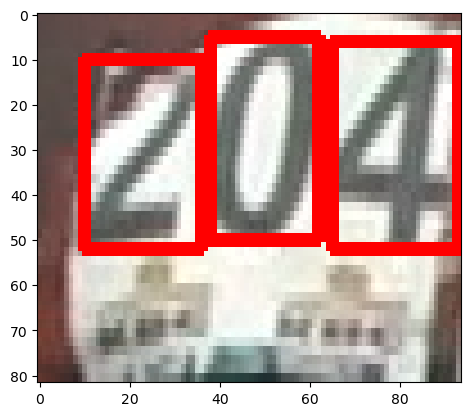

In [16]:
from ultralytics import YOLO
import os
import numpy as np
import cv2 as cv
import sys
from matplotlib import pyplot as plt

MODEL_PATH = os.path.join('runs','detect','train4','weights','best.pt')
model = YOLO(MODEL_PATH)

img = cv.imread("data/back_numbers_deinterlaced/test/images/f4b87855-7248-11ee-901a-fcb3bc5cd112.jpg")
results = model(img)
boxes = results[0].boxes.xyxy
for i in boxes:
    top = tuple([int(i[0].item()),int(i[1].item())])
    bottom = tuple([int(i[2].item()),int(i[3].item())])
    cv.rectangle(img,top,bottom, (255,0,0), 2)

plt.imshow(img)


# train model with 5000 train images

In [1]:

from ultralytics import YOLO

# Load a model
#model = YOLO("yolov8n.yaml")  # build a new model from scratch
model = YOLO("yolov8n.pt")  # load a pretrained model (recommended for training)

# Use the model
res = model.train(data="config_5000.yaml", epochs=10)  # train the model

Ultralytics YOLOv8.0.219 🚀 Python-3.11.6 torch-2.1.1+cu121 CUDA:0 (NVIDIA GeForce GTX 1080 Ti, 11172MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=config_5000.yaml, epochs=10, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train6, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True, line_width=None, forma

100%|██████████| 755k/755k [00:00<00:00, 54.3MB/s]


Overriding model.yaml nc=80 with nc=10

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytic

train: Scanning /project_ghent/mt23/number_recognition/datasets/train_5000/labels... 0 images, 5000 backgrounds, 0 corrupt: 100%|██████████| 5000/5000 [00:01<00:00, 2937.47it/s]

train: WARNING ⚠️ No labels found in /project_ghent/mt23/number_recognition/datasets/train_5000/labels.cache. See https://docs.ultralytics.com/datasets/detect for dataset formatting guidance.


train: New cache created: /project_ghent/mt23/number_recognition/datasets/train_5000/labels.cache
WARNING ⚠️ No labels found in /project_ghent/mt23/number_recognition/datasets/train_5000/labels.cache, training may not work correctly. See https://docs.ultralytics.com/datasets/detect for dataset formatting guidance.


/opt/conda/lib/python3.11/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
val: Scanning /project_ghent/mt23/number_recognition/datasets/val/labels.cache... 6000 images, 360 backgrounds, 0 corrupt: 100%|██████████| 6000/6000 [00:00<?, ?it/s]
/opt/conda/lib/python3.11/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even 

Plotting labels to runs/detect/train6/labels.jpg... 
zero-size array to reduction operation maximum which has no identity
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000714, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/train6
Starting training for 10 epochs...
Closing dataloader mosaic


/opt/conda/lib/python3.11/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10      2.43G          0      103.2          0          0        640: 100%|██████████| 313/313 [01:17<00:00,  4.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 188/188 [00:51<00:00,  3.67it/s]


                   all       6000      11700    0.00203     0.0303    0.00109   0.000204

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10      2.32G          0      59.64          0          0        640: 100%|██████████| 313/313 [01:07<00:00,  4.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 188/188 [00:29<00:00,  6.31it/s]


                   all       6000      11700    0.00203     0.0303    0.00109   0.000204

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10      2.44G          0      22.97          0          0        640: 100%|██████████| 313/313 [01:07<00:00,  4.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 188/188 [00:29<00:00,  6.44it/s]

                   all       6000      11700    0.00203     0.0303    0.00109   0.000204



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10      2.44G          0      6.751          0          0        640: 100%|██████████| 313/313 [01:06<00:00,  4.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 188/188 [00:29<00:00,  6.47it/s]

                   all       6000      11700    0.00203     0.0303    0.00109   0.000204



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10      2.32G          0      1.745          0          0        640: 100%|██████████| 313/313 [01:06<00:00,  4.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 188/188 [00:29<00:00,  6.39it/s]

                   all       6000      11700    0.00203     0.0303    0.00109   0.000204



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10      2.31G          0     0.4102          0          0        640: 100%|██████████| 313/313 [01:11<00:00,  4.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 188/188 [00:29<00:00,  6.33it/s]


                   all       6000      11700    0.00203     0.0303    0.00109   0.000204

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10      2.32G          0     0.1073          0          0        640: 100%|██████████| 313/313 [01:08<00:00,  4.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 188/188 [00:29<00:00,  6.47it/s]

                   all       6000      11700    0.00203     0.0303    0.00109   0.000204



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10      2.32G          0    0.03092          0          0        640: 100%|██████████| 313/313 [01:08<00:00,  4.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 188/188 [00:30<00:00,  6.07it/s]

                   all       6000      11700    0.00203     0.0303    0.00109   0.000204



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10      2.32G          0    0.02444          0          0        640: 100%|██████████| 313/313 [01:09<00:00,  4.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 188/188 [00:29<00:00,  6.38it/s]

                   all       6000      11700    0.00203     0.0303    0.00109   0.000204



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10      2.31G          0     0.0223          0          0        640: 100%|██████████| 313/313 [01:08<00:00,  4.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 188/188 [00:29<00:00,  6.42it/s]

                   all       6000      11700    0.00203     0.0303    0.00109   0.000204



10 epochs completed in 0.288 hours.
Optimizer stripped from runs/detect/train6/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train6/weights/best.pt, 6.2MB

Validating runs/detect/train6/weights/best.pt...
Ultralytics YOLOv8.0.219 🚀 Python-3.11.6 torch-2.1.1+cu121 CUDA:0 (NVIDIA GeForce GTX 1080 Ti, 11172MiB)
Model summary (fused): 168 layers, 3007598 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 188/188 [00:57<00:00,  3.27it/s]

                   all       6000      11700    0.00203     0.0303    0.00109   0.000204
                     0       6000        360          0          0          0          0


                     1       6000       3960   0.000259   0.000758    0.00013   2.59e-05
                     2       6000        840          0          0          0          0
                     3       6000       1620      0.019     0.0475       0.01    0.00189
                     4       6000       1440          0          0          0          0
                     5       6000        660          0          0          0          0
                     6       6000       1500          0          0          0          0
                     7       6000        600      0.001      0.255   0.000724   0.000123
                     8       6000        480          0          0          0          0
                     9       6000        240          0          0          0          0
Speed: 0.4ms preprocess, 3.6ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to runs/detect/train6


# train model with 10000 train images

In [ ]:
from ultralytics import YOLO

# Load a model
#model = YOLO("yolov8n.yaml")  # build a new model from scratch
model = YOLO("yolov8n.pt")  # load a pretrained model (recommended for training)

# Use the model
res = model.train(data="config_10000.yaml", epochs=10)  # train the model

Ultralytics YOLOv8.0.219 🚀 Python-3.11.6 torch-2.1.1+cu121 CUDA:0 (NVIDIA GeForce GTX 1080 Ti, 11172MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=config_10000.yaml, epochs=10, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train7, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True, line_width=None, form

train: Scanning /project_ghent/mt23/number_recognition/datasets/train_10000/labels... 0 images, 10000 backgrounds, 0 corrupt: 100%|██████████| 10000/10000 [00:03<00:00, 2754.88it/s]

train: WARNING ⚠️ No labels found in /project_ghent/mt23/number_recognition/datasets/train_10000/labels.cache. See https://docs.ultralytics.com/datasets/detect for dataset formatting guidance.


train: New cache created: /project_ghent/mt23/number_recognition/datasets/train_10000/labels.cache
WARNING ⚠️ No labels found in /project_ghent/mt23/number_recognition/datasets/train_10000/labels.cache, training may not work correctly. See https://docs.ultralytics.com/datasets/detect for dataset formatting guidance.


/opt/conda/lib/python3.11/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
val: Scanning /project_ghent/mt23/number_recognition/datasets/val/labels.cache... 6000 images, 360 backgrounds, 0 corrupt: 100%|██████████| 6000/6000 [00:00<?, ?it/s]
/opt/conda/lib/python3.11/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even 

Plotting labels to runs/detect/train7/labels.jpg... 
zero-size array to reduction operation maximum which has no identity
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000714, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/train7
Starting training for 10 epochs...
Closing dataloader mosaic


/opt/conda/lib/python3.11/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10      2.45G          0      91.43          0          0        640: 100%|██████████| 625/625 [02:29<00:00,  4.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 188/188 [01:02<00:00,  3.01it/s]


                   all       6000      11700   5.06e-05   0.000455   2.54e-05   2.54e-06

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10      2.32G          0      24.81          0          0        640: 100%|██████████| 625/625 [02:44<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 188/188 [00:51<00:00,  3.68it/s]


                   all       6000      11700   5.06e-05   0.000455   2.54e-05   2.54e-06

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10      2.32G          0      1.971          0          0        640: 100%|██████████| 625/625 [02:50<00:00,  3.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 188/188 [00:54<00:00,  3.47it/s]


                   all       6000      11700   5.06e-05   0.000455   2.54e-05   2.54e-06

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10      2.32G          0    0.06711          0          0        640: 100%|██████████| 625/625 [03:13<00:00,  3.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 188/188 [01:02<00:00,  3.03it/s]

                   all       6000      11700   5.06e-05   0.000455   2.54e-05   2.54e-06



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10      2.32G          0    0.01007          0          0        640: 100%|██████████| 625/625 [03:14<00:00,  3.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 188/188 [01:06<00:00,  2.81it/s]


                   all       6000      11700   5.06e-05   0.000455   2.54e-05   2.54e-06

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10      2.32G          0   0.003523          0          0        640: 100%|██████████| 625/625 [03:24<00:00,  3.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 188/188 [01:19<00:00,  2.36it/s]

                   all       6000      11700   5.06e-05   0.000455   2.54e-05   2.54e-06



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10      2.32G          0   0.002126          0          0        640: 100%|██████████| 625/625 [03:08<00:00,  3.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 188/188 [00:58<00:00,  3.24it/s]


                   all       6000      11700   5.06e-05   0.000455   2.54e-05   2.54e-06

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10      2.32G          0  0.0004378          0          0        640: 100%|██████████| 625/625 [03:15<00:00,  3.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 188/188 [00:59<00:00,  3.15it/s]


                   all       6000      11700   5.06e-05   0.000455   2.54e-05   2.54e-06

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10      2.32G          0  3.702e-05          0          0        640: 100%|██████████| 625/625 [03:28<00:00,  3.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 188/188 [01:02<00:00,  2.99it/s]


                   all       6000      11700   5.06e-05   0.000455   2.54e-05   2.54e-06

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10      2.32G          0  7.769e-07          0          0        640: 100%|██████████| 625/625 [03:31<00:00,  2.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 188/188 [01:01<00:00,  3.06it/s]


                   all       6000      11700   5.06e-05   0.000455   2.54e-05   2.54e-06

10 epochs completed in 0.725 hours.
Optimizer stripped from runs/detect/train7/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train7/weights/best.pt, 6.2MB

Validating runs/detect/train7/weights/best.pt...
Ultralytics YOLOv8.0.219 🚀 Python-3.11.6 torch-2.1.1+cu121 CUDA:0 (NVIDIA GeForce GTX 1080 Ti, 11172MiB)
Model summary (fused): 168 layers, 3007598 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  19%|█▊        | 35/188 [00:28<11:59,  4.70s/it]

# train model with 15000 train images

In [1]:
from ultralytics import YOLO

# Load a model
#model = YOLO("yolov8n.yaml")  # build a new model from scratch
model = YOLO("yolov8n.pt")  # load a pretrained model (recommended for training)

# Use the model
res = model.train(data="config_15000.yaml", epochs=10)  # train the model

Ultralytics YOLOv8.0.219 🚀 Python-3.11.6 torch-2.1.1+cu121 CUDA:0 (NVIDIA GeForce GTX 1080 Ti, 11172MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=config_15000.yaml, epochs=10, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train8, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True, line_width=None, form

train: Scanning /project_ghent/mt23/number_recognition/datasets/train_15000/labels... 2100 images, 13045 backgrounds, 0 corrupt: 100%|██████████| 15000/15000 [00:06<00:00, 2179.86it/s]


train: New cache created: /project_ghent/mt23/number_recognition/datasets/train_15000/labels.cache


/opt/conda/lib/python3.11/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
val: Scanning /project_ghent/mt23/number_recognition/datasets/val/labels.cache... 6000 images, 360 backgrounds, 0 corrupt: 100%|██████████| 6000/6000 [00:00<?, ?it/s]
/opt/conda/lib/python3.11/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even 

Plotting labels to runs/detect/train8/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000714, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/train8
Starting training for 10 epochs...
Closing dataloader mosaic


/opt/conda/lib/python3.11/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10      2.32G      1.454      19.57      1.567          0        640: 100%|██████████| 938/938 [04:42<00:00,  3.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 188/188 [01:18<00:00,  2.40it/s]


                   all       6000      11700    0.00899      0.708     0.0861     0.0456

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10      2.35G      1.444      9.552      1.553          4        640: 100%|██████████| 938/938 [04:11<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 188/188 [00:51<00:00,  3.66it/s]


                   all       6000      11700      0.075      0.592       0.21      0.109

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10      2.33G      1.466      5.038      1.506          0        640: 100%|██████████| 938/938 [03:57<00:00,  3.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 188/188 [00:46<00:00,  4.06it/s]

                   all       6000      11700      0.148      0.352      0.269      0.177



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10      2.36G      1.451      3.963      1.468          3        640: 100%|██████████| 938/938 [03:55<00:00,  3.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 188/188 [00:48<00:00,  3.87it/s]


                   all       6000      11700      0.203      0.583      0.367      0.242

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10      2.37G      1.399      3.646      1.411          2        640: 100%|██████████| 938/938 [03:55<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 188/188 [00:48<00:00,  3.86it/s]


                   all       6000      11700      0.289      0.609      0.471       0.31

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10      2.36G      1.389       3.45      1.409          3        640: 100%|██████████| 938/938 [03:55<00:00,  3.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 188/188 [00:48<00:00,  3.91it/s]


                   all       6000      11700      0.286      0.682       0.54       0.36

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10      2.36G      1.356      3.303      1.383          0        640: 100%|██████████| 938/938 [03:55<00:00,  3.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 188/188 [00:48<00:00,  3.89it/s]


                   all       6000      11700      0.284      0.709      0.555      0.359

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10      2.36G      1.343      3.243      1.369          4        640: 100%|██████████| 938/938 [03:52<00:00,  4.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 188/188 [00:50<00:00,  3.75it/s]


                   all       6000      11700      0.174      0.769      0.586      0.391

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10      2.36G      1.278      3.147      1.323          0        640: 100%|██████████| 938/938 [03:53<00:00,  4.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 188/188 [00:49<00:00,  3.81it/s]

                   all       6000      11700      0.339      0.685      0.565      0.392



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10      2.36G       1.24      3.098      1.304          2        640: 100%|██████████| 938/938 [03:54<00:00,  4.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 188/188 [00:50<00:00,  3.69it/s]


                   all       6000      11700      0.266      0.731      0.628      0.441

10 epochs completed in 0.826 hours.
Optimizer stripped from runs/detect/train8/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train8/weights/best.pt, 6.2MB

Validating runs/detect/train8/weights/best.pt...
Ultralytics YOLOv8.0.219 🚀 Python-3.11.6 torch-2.1.1+cu121 CUDA:0 (NVIDIA GeForce GTX 1080 Ti, 11172MiB)
Model summary (fused): 168 layers, 3007598 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 188/188 [00:50<00:00,  3.71it/s]


                   all       6000      11700      0.266      0.731      0.629      0.441
                     0       6000        360      0.198      0.758      0.609      0.471
                     1       6000       3960      0.246      0.799      0.712      0.461
                     2       6000        840      0.224      0.718      0.673      0.452
                     3       6000       1620       0.29      0.764      0.696      0.468
                     4       6000       1440      0.419      0.802      0.785      0.519
                     5       6000        660      0.159      0.629      0.492      0.325
                     6       6000       1500      0.273      0.692      0.584      0.406
                     7       6000        600      0.188       0.78      0.657      0.456
                     8       6000        480      0.145      0.685      0.337      0.247
                     9       6000        240      0.519      0.679      0.743      0.607
Speed: 0.3ms preproce

# train model with 20000 train images

In [53]:
from ultralytics import YOLO

# Load a model
#model = YOLO("yolov8n.yaml")  # build a new model from scratch
model = YOLO("yolov8n.pt")  # load a pretrained model (recommended for training)

# Use the model
res = model.train(data="config_20000.yaml", epochs=10)  # train the model

Ultralytics YOLOv8.0.219 🚀 Python-3.11.6 torch-2.1.1+cu121 CUDA:0 (NVIDIA GeForce GTX 1080 Ti, 11172MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=config_20000.yaml, epochs=10, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train9, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True, line_width=None, form

train: Scanning /project_ghent/mt23/number_recognition/datasets/train_20000/labels... 12100 images, 8914 backgrounds, 0 corrupt: 100%|██████████| 20000/20000 [00:13<00:00, 1524.33it/s]


train: New cache created: /project_ghent/mt23/number_recognition/datasets/train_20000/labels.cache


/opt/conda/lib/python3.11/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
val: Scanning /project_ghent/mt23/number_recognition/datasets/val/labels.cache... 6000 images, 360 backgrounds, 0 corrupt: 100%|██████████| 6000/6000 [00:00<?, ?it/s]
/opt/conda/lib/python3.11/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even 

Plotting labels to runs/detect/train9/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000714, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/train9
Starting training for 10 epochs...
Closing dataloader mosaic


/opt/conda/lib/python3.11/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10      2.37G      1.485      3.106      1.583         15        640: 100%|██████████| 1250/1250 [06:46<00:00,  3.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 188/188 [01:14<00:00,  2.54it/s]


                   all       6000      11700      0.648      0.431      0.525      0.309

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10      2.37G      1.377      1.946      1.449         26        640: 100%|██████████| 1250/1250 [08:25<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 188/188 [01:15<00:00,  2.49it/s]


                   all       6000      11700      0.782      0.531       0.61      0.412

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10      2.34G      1.328      1.717      1.409         21        640: 100%|██████████| 1250/1250 [08:56<00:00,  2.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 188/188 [01:17<00:00,  2.43it/s]


                   all       6000      11700      0.829      0.558      0.648      0.449

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10      2.35G       1.27      1.587      1.357         21        640: 100%|██████████| 1250/1250 [10:19<00:00,  2.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 188/188 [01:09<00:00,  2.69it/s]


                   all       6000      11700       0.83       0.62      0.705      0.486

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10      2.35G      1.223      1.505      1.329         15        640: 100%|██████████| 1250/1250 [09:22<00:00,  2.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 188/188 [01:11<00:00,  2.63it/s]


                   all       6000      11700      0.852      0.595      0.697      0.477

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10      2.35G      1.163      1.448      1.289         22        640: 100%|██████████| 1250/1250 [10:19<00:00,  2.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 188/188 [01:11<00:00,  2.63it/s]


                   all       6000      11700      0.823      0.573      0.694      0.474

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10      2.34G      1.105      1.371      1.257         14        640: 100%|██████████| 1250/1250 [08:49<00:00,  2.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 188/188 [01:08<00:00,  2.73it/s]


                   all       6000      11700      0.864      0.615      0.722      0.494

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10      2.34G      1.056      1.329      1.233         18        640: 100%|██████████| 1250/1250 [08:12<00:00,  2.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 188/188 [01:19<00:00,  2.37it/s]


                   all       6000      11700      0.848      0.632      0.733      0.499

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10      2.34G      1.006      1.276        1.2         12        640: 100%|██████████| 1250/1250 [09:23<00:00,  2.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 188/188 [01:17<00:00,  2.44it/s]


                   all       6000      11700      0.864      0.665      0.753      0.513

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10      2.34G     0.9576      1.243      1.181         22        640: 100%|██████████| 1250/1250 [10:08<00:00,  2.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 188/188 [01:07<00:00,  2.78it/s]


                   all       6000      11700      0.868      0.663      0.759      0.519

10 epochs completed in 1.738 hours.
Optimizer stripped from runs/detect/train9/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train9/weights/best.pt, 6.2MB

Validating runs/detect/train9/weights/best.pt...
Ultralytics YOLOv8.0.219 🚀 Python-3.11.6 torch-2.1.1+cu121 CUDA:0 (NVIDIA GeForce GTX 1080 Ti, 11172MiB)
Model summary (fused): 168 layers, 3007598 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 188/188 [01:05<00:00,  2.85it/s]


                   all       6000      11700      0.868      0.661      0.759      0.519
                     0       6000        360      0.973      0.606       0.75      0.582
                     1       6000       3960      0.831      0.655      0.759      0.516
                     2       6000        840      0.935      0.688      0.784        0.5
                     3       6000       1620      0.853      0.713      0.787      0.554
                     4       6000       1440      0.895      0.771       0.86      0.593
                     5       6000        660      0.808      0.572       0.62      0.366
                     6       6000       1500      0.839       0.69      0.778      0.519
                     7       6000        600      0.917      0.516      0.709      0.459
                     8       6000        480      0.839      0.571      0.644      0.454
                     9       6000        240      0.788      0.829      0.897      0.648
Speed: 0.6ms preproce

# train model with 25000 train images

In [1]:
from ultralytics import YOLO

# Load a model
#model = YOLO("yolov8n.yaml")  # build a new model from scratch
model = YOLO("yolov8n.pt")  # load a pretrained model (recommended for training)

# Use the model
res = model.train(data="config_25000.yaml", epochs=10)  # train the model

Ultralytics YOLOv8.0.219 🚀 Python-3.11.6 torch-2.1.1+cu121 CUDA:0 (NVIDIA GeForce GTX 1080 Ti, 11172MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=config_25000.yaml, epochs=10, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train11, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True, line_width=None, for

train: Scanning /project_ghent/mt23/number_recognition/datasets/train_25000/labels.cache... 22100 images, 4749 backgrounds, 0 corrupt: 100%|██████████| 25000/25000 [00:00<?, ?it/s]
/opt/conda/lib/python3.11/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
val: Scanning /project_ghent/mt23/number_recognition/datasets/val/labels.cache... 6000 images, 360 backgrounds, 0 corrupt: 100%|██████████| 6000/6000 [00:00<?, ?it/s]
/opt/conda/lib/python3.11/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of wo

Plotting labels to runs/detect/train11/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000714, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/train11
Starting training for 10 epochs...
Closing dataloader mosaic


/opt/conda/lib/python3.11/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10      2.32G      1.419      2.362      1.537         12        640: 100%|██████████| 1563/1563 [06:41<00:00,  3.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 188/188 [00:54<00:00,  3.47it/s]


                   all       6000      11700      0.805       0.56      0.636       0.42

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10      2.36G       1.27      1.404      1.373         17        640: 100%|██████████| 1563/1563 [06:38<00:00,  3.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 188/188 [00:50<00:00,  3.69it/s]


                   all       6000      11700      0.809       0.58      0.661       0.45

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10      2.35G      1.212      1.228       1.33         18        640: 100%|██████████| 1563/1563 [06:30<00:00,  4.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 188/188 [00:51<00:00,  3.66it/s]


                   all       6000      11700      0.837      0.616      0.707      0.469

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10      2.37G      1.145      1.118      1.283         13        640: 100%|██████████| 1563/1563 [06:31<00:00,  3.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 188/188 [00:51<00:00,  3.63it/s]


                   all       6000      11700      0.857      0.607      0.711      0.484

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10      2.38G      1.095      1.054      1.252          7        640: 100%|██████████| 1563/1563 [06:29<00:00,  4.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 188/188 [00:50<00:00,  3.71it/s]


                   all       6000      11700      0.846      0.658      0.754      0.515

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10      2.38G      1.027      0.986      1.211         11        640: 100%|██████████| 1563/1563 [06:34<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 188/188 [00:59<00:00,  3.15it/s]


                   all       6000      11700       0.87      0.656      0.749       0.52

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10      2.38G     0.9735     0.9356      1.182         11        640: 100%|██████████| 1563/1563 [06:41<00:00,  3.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 188/188 [01:08<00:00,  2.76it/s]


                   all       6000      11700       0.87      0.618      0.737      0.506

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10      2.37G     0.9211     0.8961      1.156         14        640: 100%|██████████| 1563/1563 [06:50<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 188/188 [00:53<00:00,  3.52it/s]


                   all       6000      11700      0.849      0.661      0.753      0.517

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10      2.38G     0.8747     0.8617      1.131         16        640: 100%|██████████| 1563/1563 [06:44<00:00,  3.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 188/188 [01:04<00:00,  2.91it/s]


                   all       6000      11700      0.868      0.646      0.759      0.518

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10      2.38G     0.8295     0.8248      1.113         16        640: 100%|██████████| 1563/1563 [06:53<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 188/188 [01:08<00:00,  2.76it/s]


                   all       6000      11700      0.866      0.687      0.785      0.541

10 epochs completed in 1.279 hours.
Optimizer stripped from runs/detect/train11/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train11/weights/best.pt, 6.2MB

Validating runs/detect/train11/weights/best.pt...
Ultralytics YOLOv8.0.219 🚀 Python-3.11.6 torch-2.1.1+cu121 CUDA:0 (NVIDIA GeForce GTX 1080 Ti, 11172MiB)
Model summary (fused): 168 layers, 3007598 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 188/188 [00:51<00:00,  3.63it/s]


                   all       6000      11700      0.867      0.687      0.785      0.542
                     0       6000        360      0.953      0.689       0.84      0.634
                     1       6000       3960      0.818       0.64      0.758      0.489
                     2       6000        840      0.921      0.693      0.798      0.512
                     3       6000       1620      0.886      0.712      0.814      0.591
                     4       6000       1440      0.859       0.81      0.867      0.602
                     5       6000        660      0.645      0.602      0.605      0.387
                     6       6000       1500      0.869      0.666      0.777      0.519
                     7       6000        600      0.904       0.62      0.756      0.484
                     8       6000        480      0.913      0.568       0.69      0.483
                     9       6000        240      0.901      0.867      0.944      0.716
Speed: 0.3ms preproce


remarks: need to use agnostic_nms in training to surpress different classes on the same place

# train model with image shape 450, 450 and add black borders

model uses letterbox function: https://github.com/ultralytics/ultralytics/blob/main/ultralytics/engine/predictor.py#L139
Letterbox is hier beschreven: https://github.com/ultralytics/ultralytics/blob/main/ultralytics/data/augment.py
vergroot of verkleint afbeelding to de grootste zijde de gewenste afmetingen heeft en verkleint afbeelding evenredig.
-> aspect ratio blijft behouden en dus geen vervorming.
voegt dan border toe met kleur 114, 114, 114 -> grijs
beide volgende opties lijken geen goede keuze:
optie 1: elk nummer zal een andere grootte hebben -> moeilijker
optie 2: is exact zelfde als zou gebeuren door yolo zelf maar met zwarte rande ipv grijs
wel optie om de input size wat te verkleinen zodat minder uitvergroot wordt

In [52]:
"""for file in os.listdir(os.path.join('datasets','train', 'images')):
    label_path = os.path.join('datasets','train','labels', file.split('.')[0] + '.' + file.split('.')[1] + '.txt')
    img = cv2.imread(os.path.join('datasets','train','images', file))
    new_image = np.zeros((450,450,3), dtype = int)
    h,w, _ = img.shape
    added_h = 0
    added_w = 0
    if h <450:
        added_h = 450-h
        if w<450:
            added_w = 450-w
        else:
            new_image = np.zeros((450,w,3),  dtype = int)
    else:
        if w<450:
            added_w = 450-w
            new_image = np.zeros((h,450,3),  dtype = int)
        else:
            new_image = np.zeros((h,w,3), dtype = int)
    new_image[added_h//2: added_h//2+h, added_w//2: added_w//2+w] = img
    #cv2.imwrite(os.path.join('datasets','train_450,450', 'images', file), new_image)
    with open(label_path) as f:
        with open(os.path.join('datasets','train_450,450','labels', file.split('.')[0] + '.' + file.split('.')[1] + '.txt'), 'w') as f_n:
            for line in f.readlines():
                c, tw, th, bw, bh = line.strip().split(' ')
                text = c+' '+str((float(tw)*w+added_w//2)/new_image.shape[1])+' '+str((float(th)*h+added_h//2)/new_image.shape[0])+' '+str((float(bw)*w)/new_image.shape[1])+' '+str((float(bh)*h)/new_image.shape[0])
                f_n.write(text)
                if line[-1:] == '\n':
                    f_n.write('\n')
            f_n.close()
    
    """

In [ ]:
"""from ultralytics import YOLO

# Load a model
#model = YOLO("yolov8n.yaml")  # build a new model from scratch
model = YOLO("yolov8n.pt")  # load a pretrained model (recommended for training)

# Use the model
res = model.train(data="config_450,450.yaml", epochs=10, imgsz = 450)  # train the model"""

## try model with making image square by adding black borders 

In [ ]:
"""for file in os.listdir(os.path.join('datasets','train', 'images')):
    label_path = os.path.join('datasets','train','labels', file.split('.')[0] + '.' + file.split('.')[1] + '.txt')
    img = cv2.imread(os.path.join('datasets','train','images', file))
    h,w, _ = img.shape
    shape = max(h,w)
    added_h = shape-h
    added_w = shape-w
    new_image = np.zeros((shape,shape,3), dtype = int)
    if added_h >0:
        new_image[added_h//2:added_h//2+h] = img

    else:
        if added_w > 0:
            new_image[:,added_w//2:added_w//2+w] = img
        else:
            new_image = img
    #cv2.imwrite(os.path.join('datasets','train_square', 'images', file), new_image)
    with open(label_path) as f:
        with open(os.path.join('datasets','train_square','labels', file.split('.')[0] + '.' + file.split('.')[1] + '.txt'), 'w') as f_n:
            for line in f.readlines():
                c, tw, th, bw, bh = line.strip().split(' ')
                text = c+' '+str((float(tw)*w+added_w//2)/new_image.shape[1])+' '+str((float(th)*h+added_h//2)/new_image.shape[0])+' '+str((float(bw)*w)/new_image.shape[1])+' '+str((float(bh)*h)/new_image.shape[0])
                f_n.write(text)
                if line[-1:] == '\n':
                    f_n.write('\n')
            f_n.close()
    break
"""

In [ ]:
"""from ultralytics import YOLO

# Load a model
#model = YOLO("yolov8n.yaml")  # build a new model from scratch
model = YOLO("yolov8n.pt")  # load a pretrained model (recommended for training)

# Use the model
res = model.train(data="config_square.yaml", epochs=10, imgsz = 450)  # train the model"""

## train model with image size = 450

In [2]:
from ultralytics import YOLO

# Load a model
#model = YOLO("yolov8n.yaml")  # build a new model from scratch
model = YOLO("yolov8n.pt")  # load a pretrained model (recommended for training)

# Use the model
res = model.train(data="config.yaml", epochs=10, imgsz = 450)  # train the model
#run 12

Ultralytics YOLOv8.0.219 🚀 Python-3.11.6 torch-2.1.1+cu121 CUDA:0 (NVIDIA GeForce GTX 1080 Ti, 11172MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=config.yaml, epochs=10, patience=50, batch=16, imgsz=450, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train12, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True, line_width=None, format=to

train: Scanning /project_ghent/mt23/number_recognition/datasets/train/labels.cache... 27900 images, 2340 backgrounds, 0 corrupt: 100%|██████████| 27900/27900 [00:00<?, ?it/s]
/opt/conda/lib/python3.11/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
val: Scanning /project_ghent/mt23/number_recognition/datasets/val/labels.cache... 6000 images, 360 backgrounds, 0 corrupt: 100%|██████████| 6000/6000 [00:00<?, ?it/s]
/opt/conda/lib/python3.11/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker i

Plotting labels to runs/detect/train12/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000714, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 480 train, 480 val
Using 8 dataloader workers
Logging results to runs/detect/train12
Starting training for 10 epochs...
Closing dataloader mosaic


/opt/conda/lib/python3.11/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10      1.26G      1.394      1.987      1.419         26        480: 100%|██████████| 1744/1744 [05:18<00:00,  5.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 188/188 [00:49<00:00,  3.80it/s]


                   all       6000      11700      0.814       0.55      0.645      0.435

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10      1.29G      1.232      1.202      1.259         25        480: 100%|██████████| 1744/1744 [05:06<00:00,  5.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 188/188 [00:42<00:00,  4.39it/s]


                   all       6000      11700      0.816      0.578      0.651      0.426

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10      1.26G      1.165      1.041      1.208         22        480: 100%|██████████| 1744/1744 [05:01<00:00,  5.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 188/188 [00:44<00:00,  4.26it/s]


                   all       6000      11700      0.829      0.622      0.705       0.49

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10      1.39G       1.09     0.9418      1.163         20        480: 100%|██████████| 1744/1744 [05:02<00:00,  5.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 188/188 [00:46<00:00,  4.00it/s]


                   all       6000      11700      0.833      0.637      0.735      0.503

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10      1.27G      1.041     0.8756      1.135         23        480: 100%|██████████| 1744/1744 [05:02<00:00,  5.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 188/188 [00:44<00:00,  4.22it/s]


                   all       6000      11700      0.836      0.672      0.755      0.516

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10      1.27G     0.9841     0.8138      1.107         30        480: 100%|██████████| 1744/1744 [05:04<00:00,  5.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 188/188 [00:46<00:00,  4.07it/s]


                   all       6000      11700      0.846      0.666      0.759      0.523

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10      1.26G     0.9255     0.7605       1.08         24        480: 100%|██████████| 1744/1744 [05:05<00:00,  5.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 188/188 [00:47<00:00,  3.92it/s]


                   all       6000      11700      0.855      0.671      0.762      0.522

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10      1.38G     0.8812     0.7219      1.061         23        480: 100%|██████████| 1744/1744 [05:03<00:00,  5.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 188/188 [00:47<00:00,  3.99it/s]


                   all       6000      11700      0.849      0.684       0.77      0.535

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10      1.26G     0.8337     0.6807      1.039         24        480: 100%|██████████| 1744/1744 [05:08<00:00,  5.65it/s] 
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 188/188 [00:45<00:00,  4.10it/s]


                   all       6000      11700      0.866      0.699       0.78      0.535

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10      1.38G     0.7933     0.6422      1.023         25        480: 100%|██████████| 1744/1744 [05:05<00:00,  5.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 188/188 [00:45<00:00,  4.09it/s]


                   all       6000      11700      0.858        0.7      0.782      0.545

10 epochs completed in 0.994 hours.
Optimizer stripped from runs/detect/train12/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train12/weights/best.pt, 6.2MB

Validating runs/detect/train12/weights/best.pt...
Ultralytics YOLOv8.0.219 🚀 Python-3.11.6 torch-2.1.1+cu121 CUDA:0 (NVIDIA GeForce GTX 1080 Ti, 11172MiB)
Model summary (fused): 168 layers, 3007598 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 188/188 [00:48<00:00,  3.85it/s]


                   all       6000      11700      0.857        0.7      0.782      0.545
                     0       6000        360      0.832      0.731      0.831      0.599
                     1       6000       3960      0.863      0.635       0.77      0.503
                     2       6000        840      0.872      0.663      0.793      0.526
                     3       6000       1620      0.914      0.773      0.841      0.592
                     4       6000       1440      0.919      0.802      0.885      0.622
                     5       6000        660      0.758      0.555      0.614      0.414
                     6       6000       1500       0.84      0.773      0.836      0.587
                     7       6000        600      0.753      0.621      0.675      0.439
                     8       6000        480       0.86      0.554      0.628      0.447
                     9       6000        240       0.96      0.889      0.948      0.725
Speed: 0.2ms preproce

## train model with agnosic_nms

In [3]:
from ultralytics import YOLO

# Load a model
#model = YOLO("yolov8n.yaml")  # build a new model from scratch
model = YOLO("yolov8n.pt")  # load a pretrained model (recommended for training)

# Use the model
res = model.train(data="config.yaml", epochs=10,agnostic_nms = True)  # train the model
#run 13

Ultralytics YOLOv8.0.219 🚀 Python-3.11.6 torch-2.1.1+cu121 CUDA:0 (NVIDIA GeForce GTX 1080 Ti, 11172MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=config.yaml, epochs=10, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train13, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=True, classes=None, retina_masks=False, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True, line_width=None, format=tor

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa843fd8400>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1442, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/opt/conda/lib/python3.11/multiprocessing/process.py", line 149, in join
    res = self._popen.wait(timeout)
          ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/conda/lib/python3.11/multiprocessing/popen_fork.py", line 40, in wait
    if not wait([self.sentinel], timeout):
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/conda/lib/python3.11/multiprocessing/connection.py", line 947, in wait
    ready = selector.select(timeout)
            ^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/conda/lib/python3.11/selectors.py", line 415, in select
    fd_event_list = self._sele

Model summary: 225 layers, 3012798 parameters, 3012782 gradients, 8.2 GFLOPs

Transferred 319/355 items from pretrained weights
TensorBoard: Start with 'tensorboard --logdir runs/detect/train13', view at http://localhost:6006/
Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


KeyboardInterrupt: 